# Imports and connection

In [67]:
import math
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

import datetime as dt
import time
import logging

import black_scholes
import libs

from optibook.synchronous_client import Exchange

from cointegration_analysis import estimate_long_run_short_run_relationships, engle_granger_two_step_cointegration_test
import functions as fun

In [2]:
exchange = Exchange()
exchange.connect()

logging.getLogger('client').setLevel('ERROR')

2022-03-31 15:03:01,572 [asyncio   ] [MainThread  ] Using selector: EpollSelector
2022-03-31 15:03:01,575 [client    ] [Thread-4    ] background thread started
2022-03-31 15:03:01,604 [client    ] [Thread-4    ] opened connection
2022-03-31 15:03:01,606 [client    ] [Thread-4    ] start read <StreamReader t=<_SelectorSocketTransport fd=91 read=polling write=<idle, bufsize=0>>>
2022-03-31 15:03:01,616 [client    ] [Thread-4    ] logged in!


# Analysis cointegrating pairs

## Get history data

In [4]:
def getMeanPrice(instrument_id):
    orderbook = exchange.get_last_price_book(instrument_id)
    if orderbook.bids and orderbook.asks:
        return (orderbook.bids[0].price + orderbook.asks[0].price) / 2

def getHistoryPricesInArray(name1, name2, name3, trackLength = 1000):
    name1_array = []
    name2_array = []
    name3_array = []
    listXaxis = list(range(trackLength))
    
    counter = 0
    while counter < trackLength :
        
        name1_array.append(getMeanPrice(name1))
        name2_array.append(getMeanPrice(name2))
        name3_array.append(getMeanPrice(name3))
        
        counter += 1
        time.sleep(1)
        
    dict = {name1: name1_array, name2: name2_array, name3: name3_array} 
    df = pd.DataFrame(dict)
    
    return df

In [5]:
stock_ids = ['ADYEN', 'KPN', 'TKWY']
df = getHistoryPricesInArray(stock_ids[0],stock_ids[1],stock_ids[2])
df

,ADYEN,KPN,TKWY
0,76.25,61.15,25.75
1,76.30,61.15,25.95
2,76.30,61.05,25.75
3,76.25,61.05,26.20
4,76.20,61.05,25.75
...,...,...,...
995,76.75,61.00,25.65
996,76.70,61.00,25.70
997,76.65,61.00,25.80
998,76.65,60.75,NaN


In [6]:
df = df.dropna()
df_logs = np.log(df)
display(df_logs)

,ADYEN,KPN,TKWY
0,4.334017,4.113330,3.248435
1,4.334673,4.113330,3.256172
2,4.334673,4.111693,3.248435
3,4.334017,4.111693,3.265759
4,4.333361,4.111693,3.248435
...,...,...,...
994,4.339250,4.110054,3.248435
995,4.340553,4.110874,3.244544
996,4.339902,4.110874,3.246491
997,4.339250,4.110874,3.250374


In [7]:
threshold = 0.01

companies_list = df_logs.columns

for i in range(0, len(companies_list)):
    for j in range(i + 1, len(companies_list)):
        c, gamma, alpha, z = estimate_long_run_short_run_relationships(df_logs[companies_list[i]], df_logs[companies_list[j]])
        dfstat, pval = engle_granger_two_step_cointegration_test(df_logs[companies_list[i]], df_logs[companies_list[j]])
        if(pval < threshold):
            
            print(f'COMPANY 1: {companies_list[i]}   COMPANY 2: {companies_list[j]}   P-VALUE: {pval}   DF-STAT: {dfstat}   CONSTANT: {c}   SLOPE: {gamma}   STRENGTH: {alpha} \n')

COMPANY 1: ADYEN   COMPANY 2: KPN   P-VALUE: 2.860326687687085e-16   DF-STAT: -9.532827079929383   CONSTANT: 0.5764304015487625   SLOPE: 0.9146046666107015   STRENGTH: -0.23268125720894067 

COMPANY 1: ADYEN   COMPANY 2: TKWY   P-VALUE: 4.855489331158068e-06   DF-STAT: -5.3251569106119625   CONSTANT: 5.209410136095286   SLOPE: -0.27010663196564444   STRENGTH: -0.13195697578223384 

COMPANY 1: KPN   COMPANY 2: TKWY   P-VALUE: 1.78463731676507e-07   DF-STAT: -5.986754477968879   CONSTANT: 4.709983588239027   SLOPE: -0.18556036285991162   STRENGTH: -0.2867268035142976 



## Find optimal z-threshold

In [20]:
def subfindOptimalZValue(threshold, zData):
    chance = 0
    startHigh = False
    startLow = False
    for i in range(len(zData.values)):
        if startHigh == True:
            if (zData.values[i] < -threshold):
                chance += 1 
                startHigh = False
        elif startLow == True:
            if (zData.values[i] > threshold):
                chance += 1 
                startLow = False
        else:
            if (zData.values[i] > threshold):
                startHigh = True
            if (zData.values[i] < -threshold):
                startLow = True
    return (chance * (2* threshold))

def findOptimalZValue(zData, title):
    testThresholds = np.arange(0.000, 0.005, 0.0001)
    profits = []
    for tT in testThresholds:
        profits.append(subfindOptimalZValue(tT, zData))
        #print(f'Threshold value :{tT}, profit : {subfindOptimalZValue(tT, zData)}')
        
    profits_df = pd.DataFrame()
    profits_df['profits'] = profits
    profits_df['z'] = testThresholds
    
    plt.title(f'Optimal Z-threshold of {title}')
    plt.xlabel('z-threshold value')
    plt.ylabel('Expected profit')
    plt.plot(profits_df['z'], profits_df['profits'])
    
    bestZ = round((profits_df[profits_df['profits'] == profits_df['profits'].max()]['z'].values)[0], 4)
    bestProfit = round((profits_df[profits_df['profits'] == profits_df['profits'].max()]['profits'].values)[0], 4)
    
    plt.plot(bestZ, bestProfit, 'r*')
    plt.text(bestZ, bestProfit, '({}, {})'.format(bestZ, bestProfit))

### ADYEN and KPN

Text(0.5, 1.0, 'Z-value ADYEN to KPN')

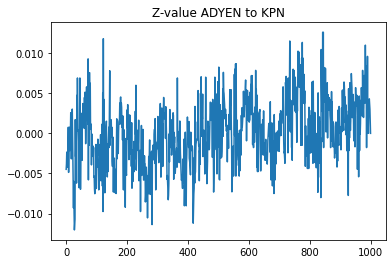

In [16]:
c_adyen_kpn = 0.5764304015487625
gamma_adyen_kpn = 0.9146046666107015 

yt_adyen = df_logs['ADYEN']
xt_kpn = df_logs['KPN']

zt_adyen_kpn = yt_adyen - c_adyen_kpn - gamma_adyen_kpn * xt_kpn

plt.plot(zt_adyen_kpn) 
plt.title('Z-value ADYEN to KPN')

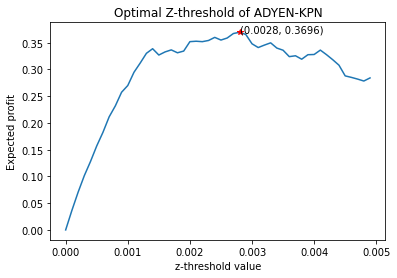

In [21]:
findOptimalZValue(zt_adyen_kpn, "ADYEN-KPN")

### ADYEN and TKWY

Text(0.5, 1.0, 'Z-value ADYEN to TKWY')

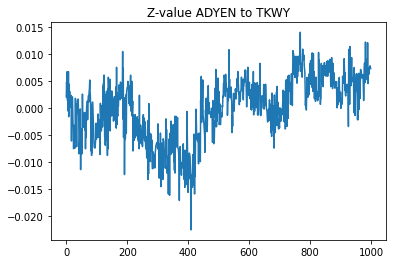

In [39]:
c_adyen_tkwy = 5.209410136095286
gamma_adyen_tkwy = -0.27010663196564444

yt_adyen = df_logs['ADYEN']
xt_tkwy = df_logs['TKWY']

zt_adyen_tkwy = yt_adyen - c_adyen_tkwy - gamma_adyen_tkwy * xt_tkwy

plt.plot(zt_adyen_tkwy) 
plt.title('Z-value ADYEN to TKWY')

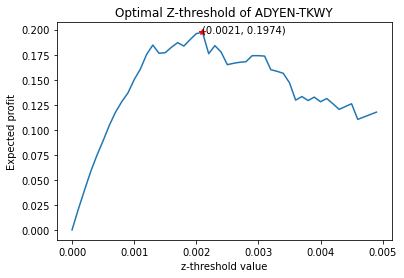

In [26]:
findOptimalZValue(zt_adyen_tkwy, "ADYEN-TKWY")

### KPN and TKWY

Text(0.5, 1.0, 'Z-value KPN-TKWY')

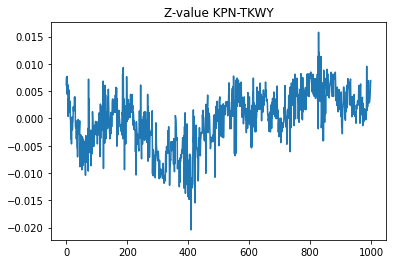

In [40]:
c_kpn_tkwy = 4.709983588239027
gamma_kpn_tkwy = -0.18556036285991162

yt_kpn = df_logs['KPN']
xt_tkwy = df_logs['TKWY']

zt_kpn_tkwy = yt_kpn - c_kpn_tkwy - gamma_kpn_tkwy * xt_tkwy


plt.plot(zt_kpn_tkwy) 
plt.title('Z-value KPN-TKWY')

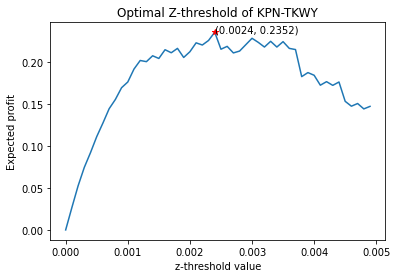

In [41]:
findOptimalZValue(zt_kpn_tkwy, "KPN-TKWY")

## Find ratio

In [76]:
def getRatio(yt, xt, gamma, title):
    ratio_arr = []
    
    counter = 0
    while counter < len(yt):
        ratio_arr.append((gamma * (yt[i] / xt[i]))) 
        counter += 1

    plt.plot(ratio_arr)
    print(f'Mean of the ratio of {title} is: {np.mean(ratio_arr)}')

### ADYEN - KPN

Mean of the ratio of ADYEN-KPN is: 0.9654649401138333


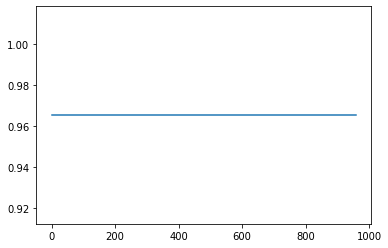

In [77]:
getRatio(yt_adyen, xt_kpn, gamma_adyen_kpn, "ADYEN-KPN")

### ADYEN - TKWY

Mean of the ratio of ADYEN-TKWY is: -0.36227715287099904


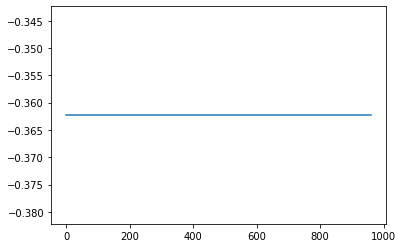

In [79]:
getRatio(yt_adyen, xt_tkwy, gamma_adyen_tkwy, "ADYEN-TKWY")

### KPN - TKWY

Mean of the ratio of KPN-TKWY is: -0.23576960559629112


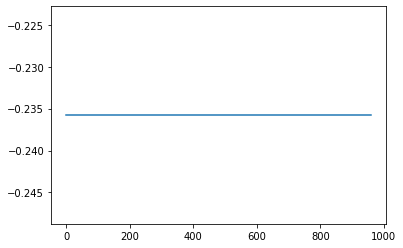

In [80]:
getRatio(yt_kpn, xt_tkwy, gamma_kpn_tkwy, "KPN-TKWY")

# Algorithm NOT DONE YET SO DONT RUN

In [ ]:
position_limit = 100

# Obtain pair objects which hold all relevant information for each of the three tradeable pairs
(pair_adyen_kpn, pair_adyen_tkwy, pair_kpn_tkwy) = fun.get_tradeable_pairs()

# Main loop
while True:
    
    # During each main loop, run the procedure for each of the three tradeable pairs
    for pair in [pair_adyen_kpn, pair_adyen_tkwy, pair_kpn_tkwy]:
        instrument_a = pair.instrument_a
        instrument_b = pair.instrument_b
        constant = pair.constant
        slope = pair.gamma
        # Hedge Ratio: gamma * y / x. Use a pre-calculated ratio based on historical data 
        hedge_ratio = pair.hedge_ratio
        # Threshold: the value of Z for which (times it occurs * profit when it occurs) is maximal - pair specific
        threshold = pair.optimal_threshold
        
        # Obtain relevant trading information
        position_a, position_b, order_book_a, order_book_b = fun.get_positions_and_order_book(exchange, instrument_a, instrument_b)
        if fun.order_books_are_not_empty(order_book_a, order_book_b):
            
            # Extract information from the order books, and use this to calculate two Z-values
            # Invariant: Z1 < Z2
            best_ask_a, best_bid_a = order_book_a.asks[0], order_book_a.bids[0]
            best_ask_b, best_bid_b = order_book_b.asks[0], order_book_b.bids[0]
            z_1 = - constant - slope * np.log(best_ask_b.price) + np.log(best_bid_a.price)
            z_2 = - constant - slope * np.log(best_bid_b.price) + np.log(best_ask_a.price)
            
            # Case where A is overvalued compared to B; short A and go long in B
            if(z_1 > threshold):
                # In the pair, B is always the (in absolute terms) cheaper stock. Therefore, we always have more absolute position in B
                # when properly hedged (which is maintained as an invariant of the main loop termination), and thus we only need to check B's limits.
                if(position_b < position_limit):
                    order_size = min(position_limit - position_b, best_ask_b.volume)
                    exchange.insert_order(instrument_b, price=best_ask_b.price, volume=order_size, side='bid', order_type='ioc')
                    # Verify whether and how much of the order on B came through
                    # If it (partly) came through, hedge in A according to the hedging ratio
                    fulfilled_volume = abs(exchange.get_positions()[instrument_b] - position_b)
                    if(fulfilled_volume):
                        exchange.insert_order(instrument_a, price=best_bid_a.price, volume=int(round(fulfilled_volume/hedge_ratio, 0)), side='ask', order_type='ioc')
                        
            # Case where B is overvalued compared to A; short B and go long in A
            # Since Z1 < Z2 always holds, at most 1 of these if-statements can fire per iteration
            # The following is otherwise simply mirroring the previous block of code
            if(z_2 < -threshold):
                if(position_b > -position_limit):
                    order_size = min(position_limit + position_b, best_bid_b.volume)
                    exchange.insert_order(instrument_b, price=best_bid_b.price, volume=order_size, side='ask', order_type='ioc')
                    fulfilled_volume = abs(exchange.get_positions()[instrument_b] - position_b)
                    if(fulfilled_volume):
                        exchange.insert_order(instrument_a, price=best_ask_a.price, volume=int(round(fulfilled_volume/hedge_ratio, 0)), side='bid', order_type='ioc')
                        
        # Sometimes, the second order does not fall through, thus, we check whether we are properly hedged. 
        # If not, immediately hedge at the best available costs. 
        # Thus, we maintain the invariant that we are always properly hedged during termination of the main loop.
        position_a, position_b, order_book_a, order_book_b = fun.get_positions_and_order_book(exchange, instrument_a, instrument_b)
        while fun.unhedged(position_a, position_b, hedge_ratio):
            if fun.order_books_are_not_empty(order_book_a, order_book_b):
                fun.try_hedge(exchange, position_a, position_b, order_book_a, instrument_a, hedge_ratio)
            position_a, position_b, order_book_a, order_book_b= fun.get_positions_and_order_book(exchange, instrument_a, instrument_b)
                